# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 1200
lr = 0.5e-7
batch_size = 10
num_workers = 1

### Create Model

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:0')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:0 dtype <class 'torch.cuda.FloatTensor'>


### Handle loss function and optimizer

### Track stats

### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0.05, 0.1]#, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [10]:
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
    model = resnet18(drop_prob=drop_prob)
    model = model.to(device)
    
    crit = torch.nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    stats = np.zeros(shape=(num_epoch, 2, 2))

    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1


    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

    #         print(pred)
    #         print(labels)
    #         print()

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.6f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0.05
Epoch:    1 Tr loss: 3.361030 Ts loss: 2.988 Tr Accuracy: 6.41% Ts Accuracy: 4.40% Time: 2.59s p=0.05 save!
Epoch:    2 Tr loss: 3.341277 Ts loss: 2.940 Tr Accuracy: 6.76% Ts Accuracy: 4.99% Time: 4.52s p=0.05 save!
Epoch:    3 Tr loss: 3.297148 Ts loss: 2.930 Tr Accuracy: 5.84% Ts Accuracy: 5.57% Time: 6.56s p=0.05 save!
Epoch:    4 Tr loss: 3.231894 Ts loss: 2.898 Tr Accuracy: 6.19% Ts Accuracy: 6.16% Time: 8.54s p=0.05 save!
Epoch:    5 Tr loss: 3.263101 Ts loss: 2.856 Tr Accuracy: 5.50% Ts Accuracy: 4.69% Time: 10.61s p=0.05 
Epoch:    6 Tr loss: 3.211507 Ts loss: 2.851 Tr Accuracy: 5.84% Ts Accuracy: 6.45% Time: 12.57s p=0.05 save!
Epoch:    7 Tr loss: 3.126768 Ts loss: 2.864 Tr Accuracy: 6.07% Ts Accuracy: 6.16% Time: 14.60s p=0.05 
Epoch:    8 Tr loss: 3.088775 Ts loss: 2.806 Tr Accuracy: 6.76% Ts Accuracy: 5.57% Time: 16.74s p=0.05 
Epoch:    9 Tr loss: 3.116505 Ts loss: 2.772 Tr Accuracy: 5.04% Ts Accuracy: 6.74% Time: 18.75s p=0.05 save!
Epoch:   10 Tr loss: 3

Epoch:   77 Tr loss: 2.116125 Ts loss: 2.051 Tr Accuracy: 23.37% Ts Accuracy: 26.10% Time: 147.15s p=0.05 
Epoch:   78 Tr loss: 2.115184 Ts loss: 2.066 Tr Accuracy: 23.94% Ts Accuracy: 28.45% Time: 149.05s p=0.05 
Epoch:   79 Tr loss: 2.076418 Ts loss: 2.057 Tr Accuracy: 24.74% Ts Accuracy: 28.45% Time: 150.92s p=0.05 
Epoch:   80 Tr loss: 2.102549 Ts loss: 2.040 Tr Accuracy: 24.28% Ts Accuracy: 30.79% Time: 152.83s p=0.05 save!
Epoch:   81 Tr loss: 2.046576 Ts loss: 2.029 Tr Accuracy: 26.35% Ts Accuracy: 29.62% Time: 154.74s p=0.05 
Epoch:   82 Tr loss: 2.056598 Ts loss: 2.028 Tr Accuracy: 25.09% Ts Accuracy: 29.03% Time: 156.68s p=0.05 
Epoch:   83 Tr loss: 2.088903 Ts loss: 2.019 Tr Accuracy: 24.40% Ts Accuracy: 29.33% Time: 158.63s p=0.05 
Epoch:   84 Tr loss: 2.036701 Ts loss: 2.014 Tr Accuracy: 25.66% Ts Accuracy: 31.67% Time: 160.56s p=0.05 save!
Epoch:   85 Tr loss: 2.010943 Ts loss: 2.005 Tr Accuracy: 29.21% Ts Accuracy: 29.62% Time: 162.45s p=0.05 
Epoch:   86 Tr loss: 2.0460

Epoch:  153 Tr loss: 1.689679 Ts loss: 1.752 Tr Accuracy: 40.21% Ts Accuracy: 48.39% Time: 288.16s p=0.05 save!
Epoch:  154 Tr loss: 1.661808 Ts loss: 1.695 Tr Accuracy: 43.07% Ts Accuracy: 48.39% Time: 290.02s p=0.05 
Epoch:  155 Tr loss: 1.685053 Ts loss: 1.722 Tr Accuracy: 41.58% Ts Accuracy: 47.80% Time: 291.97s p=0.05 
Epoch:  156 Tr loss: 1.659054 Ts loss: 1.686 Tr Accuracy: 43.30% Ts Accuracy: 49.27% Time: 293.98s p=0.05 save!
Epoch:  157 Tr loss: 1.672507 Ts loss: 1.764 Tr Accuracy: 42.73% Ts Accuracy: 47.80% Time: 295.80s p=0.05 
Epoch:  158 Tr loss: 1.665809 Ts loss: 1.673 Tr Accuracy: 43.07% Ts Accuracy: 48.09% Time: 297.64s p=0.05 
Epoch:  159 Tr loss: 1.651576 Ts loss: 1.716 Tr Accuracy: 41.70% Ts Accuracy: 49.56% Time: 299.49s p=0.05 save!
Epoch:  160 Tr loss: 1.670223 Ts loss: 1.681 Tr Accuracy: 42.61% Ts Accuracy: 50.15% Time: 301.27s p=0.05 save!
Epoch:  161 Tr loss: 1.616872 Ts loss: 1.694 Tr Accuracy: 45.48% Ts Accuracy: 47.80% Time: 303.08s p=0.05 
Epoch:  162 Tr lo

Epoch:  229 Tr loss: 1.399245 Ts loss: 1.492 Tr Accuracy: 54.75% Ts Accuracy: 55.43% Time: 428.44s p=0.05 
Epoch:  230 Tr loss: 1.422516 Ts loss: 1.462 Tr Accuracy: 52.23% Ts Accuracy: 56.89% Time: 430.40s p=0.05 save!
Epoch:  231 Tr loss: 1.425582 Ts loss: 1.485 Tr Accuracy: 53.95% Ts Accuracy: 56.01% Time: 432.40s p=0.05 
Epoch:  232 Tr loss: 1.417287 Ts loss: 1.464 Tr Accuracy: 54.30% Ts Accuracy: 54.55% Time: 434.25s p=0.05 
Epoch:  233 Tr loss: 1.406875 Ts loss: 1.484 Tr Accuracy: 53.26% Ts Accuracy: 55.43% Time: 436.02s p=0.05 
Epoch:  234 Tr loss: 1.399897 Ts loss: 1.444 Tr Accuracy: 55.67% Ts Accuracy: 55.43% Time: 437.85s p=0.05 
Epoch:  235 Tr loss: 1.416629 Ts loss: 1.481 Tr Accuracy: 52.35% Ts Accuracy: 55.72% Time: 439.61s p=0.05 
Epoch:  236 Tr loss: 1.402438 Ts loss: 1.466 Tr Accuracy: 54.30% Ts Accuracy: 56.01% Time: 441.40s p=0.05 
Epoch:  237 Tr loss: 1.390872 Ts loss: 1.512 Tr Accuracy: 56.70% Ts Accuracy: 54.25% Time: 443.21s p=0.05 
Epoch:  238 Tr loss: 1.396526 Ts

Epoch:  306 Tr loss: 1.243415 Ts loss: 1.283 Tr Accuracy: 59.11% Ts Accuracy: 59.82% Time: 581.55s p=0.05 
Epoch:  307 Tr loss: 1.236734 Ts loss: 1.315 Tr Accuracy: 60.71% Ts Accuracy: 58.65% Time: 583.37s p=0.05 
Epoch:  308 Tr loss: 1.234321 Ts loss: 1.337 Tr Accuracy: 60.71% Ts Accuracy: 58.94% Time: 585.20s p=0.05 
Epoch:  309 Tr loss: 1.266455 Ts loss: 1.305 Tr Accuracy: 58.99% Ts Accuracy: 58.06% Time: 587.07s p=0.05 
Epoch:  310 Tr loss: 1.248298 Ts loss: 1.334 Tr Accuracy: 58.88% Ts Accuracy: 58.65% Time: 588.93s p=0.05 
Epoch:  311 Tr loss: 1.221147 Ts loss: 1.311 Tr Accuracy: 61.86% Ts Accuracy: 58.36% Time: 590.75s p=0.05 
Epoch:  312 Tr loss: 1.233773 Ts loss: 1.305 Tr Accuracy: 59.11% Ts Accuracy: 59.82% Time: 592.53s p=0.05 
Epoch:  313 Tr loss: 1.231524 Ts loss: 1.308 Tr Accuracy: 60.60% Ts Accuracy: 57.77% Time: 594.32s p=0.05 
Epoch:  314 Tr loss: 1.238562 Ts loss: 1.339 Tr Accuracy: 61.40% Ts Accuracy: 61.00% Time: 596.09s p=0.05 
Epoch:  315 Tr loss: 1.237461 Ts loss

Epoch:  383 Tr loss: 1.128379 Ts loss: 1.173 Tr Accuracy: 64.38% Ts Accuracy: 63.34% Time: 722.17s p=0.05 
Epoch:  384 Tr loss: 1.137691 Ts loss: 1.160 Tr Accuracy: 62.20% Ts Accuracy: 61.88% Time: 723.87s p=0.05 
Epoch:  385 Tr loss: 1.126435 Ts loss: 1.187 Tr Accuracy: 63.80% Ts Accuracy: 62.76% Time: 725.55s p=0.05 
Epoch:  386 Tr loss: 1.107885 Ts loss: 1.165 Tr Accuracy: 64.15% Ts Accuracy: 63.05% Time: 727.21s p=0.05 
Epoch:  387 Tr loss: 1.098599 Ts loss: 1.153 Tr Accuracy: 65.75% Ts Accuracy: 63.05% Time: 729.05s p=0.05 
Epoch:  388 Tr loss: 1.108233 Ts loss: 1.231 Tr Accuracy: 64.38% Ts Accuracy: 62.76% Time: 730.83s p=0.05 
Epoch:  389 Tr loss: 1.109992 Ts loss: 1.156 Tr Accuracy: 64.26% Ts Accuracy: 61.58% Time: 732.62s p=0.05 
Epoch:  390 Tr loss: 1.109759 Ts loss: 1.130 Tr Accuracy: 64.38% Ts Accuracy: 61.88% Time: 734.41s p=0.05 
Epoch:  391 Tr loss: 1.107637 Ts loss: 1.217 Tr Accuracy: 65.06% Ts Accuracy: 62.76% Time: 736.15s p=0.05 
Epoch:  392 Tr loss: 1.113545 Ts loss

Epoch:  460 Tr loss: 1.014926 Ts loss: 1.094 Tr Accuracy: 67.12% Ts Accuracy: 66.28% Time: 855.12s p=0.05 
Epoch:  461 Tr loss: 1.025728 Ts loss: 1.034 Tr Accuracy: 65.64% Ts Accuracy: 65.69% Time: 857.03s p=0.05 
Epoch:  462 Tr loss: 1.005319 Ts loss: 1.072 Tr Accuracy: 69.99% Ts Accuracy: 66.86% Time: 858.81s p=0.05 
Epoch:  463 Tr loss: 0.994764 Ts loss: 1.073 Tr Accuracy: 69.30% Ts Accuracy: 65.69% Time: 860.57s p=0.05 
Epoch:  464 Tr loss: 1.027968 Ts loss: 1.069 Tr Accuracy: 67.01% Ts Accuracy: 64.52% Time: 862.39s p=0.05 
Epoch:  465 Tr loss: 1.016496 Ts loss: 1.087 Tr Accuracy: 66.32% Ts Accuracy: 64.81% Time: 864.23s p=0.05 
Epoch:  466 Tr loss: 1.001487 Ts loss: 1.084 Tr Accuracy: 69.07% Ts Accuracy: 65.98% Time: 866.08s p=0.05 
Epoch:  467 Tr loss: 1.011091 Ts loss: 1.090 Tr Accuracy: 65.98% Ts Accuracy: 65.40% Time: 867.93s p=0.05 
Epoch:  468 Tr loss: 1.010471 Ts loss: 1.064 Tr Accuracy: 66.90% Ts Accuracy: 65.98% Time: 869.77s p=0.05 
Epoch:  469 Tr loss: 1.029447 Ts loss

Epoch:  537 Tr loss: 0.927135 Ts loss: 0.987 Tr Accuracy: 70.56% Ts Accuracy: 70.38% Time: 987.88s p=0.05 save!
Epoch:  538 Tr loss: 0.947189 Ts loss: 1.021 Tr Accuracy: 68.50% Ts Accuracy: 68.04% Time: 989.49s p=0.05 
Epoch:  539 Tr loss: 0.925380 Ts loss: 0.974 Tr Accuracy: 69.99% Ts Accuracy: 68.62% Time: 991.11s p=0.05 
Epoch:  540 Tr loss: 0.940326 Ts loss: 1.005 Tr Accuracy: 70.33% Ts Accuracy: 69.21% Time: 992.79s p=0.05 
Epoch:  541 Tr loss: 0.941262 Ts loss: 1.048 Tr Accuracy: 69.53% Ts Accuracy: 67.45% Time: 994.51s p=0.05 
Epoch:  542 Tr loss: 0.913998 Ts loss: 0.990 Tr Accuracy: 71.36% Ts Accuracy: 68.91% Time: 996.14s p=0.05 
Epoch:  543 Tr loss: 0.920295 Ts loss: 0.982 Tr Accuracy: 70.22% Ts Accuracy: 67.16% Time: 997.88s p=0.05 
Epoch:  544 Tr loss: 0.929450 Ts loss: 0.976 Tr Accuracy: 71.48% Ts Accuracy: 70.38% Time: 999.47s p=0.05 
Epoch:  545 Tr loss: 0.917732 Ts loss: 0.997 Tr Accuracy: 69.76% Ts Accuracy: 69.50% Time: 1001.07s p=0.05 
Epoch:  546 Tr loss: 0.941574 T

Epoch:  613 Tr loss: 0.891655 Ts loss: 0.912 Tr Accuracy: 70.56% Ts Accuracy: 70.67% Time: 1113.40s p=0.05 
Epoch:  614 Tr loss: 0.849892 Ts loss: 0.935 Tr Accuracy: 72.39% Ts Accuracy: 69.50% Time: 1115.00s p=0.05 
Epoch:  615 Tr loss: 0.859548 Ts loss: 0.949 Tr Accuracy: 73.77% Ts Accuracy: 70.67% Time: 1116.58s p=0.05 
Epoch:  616 Tr loss: 0.884440 Ts loss: 0.907 Tr Accuracy: 71.25% Ts Accuracy: 70.97% Time: 1118.25s p=0.05 
Epoch:  617 Tr loss: 0.871058 Ts loss: 0.939 Tr Accuracy: 71.59% Ts Accuracy: 70.38% Time: 1119.89s p=0.05 
Epoch:  618 Tr loss: 0.853309 Ts loss: 0.906 Tr Accuracy: 72.16% Ts Accuracy: 72.73% Time: 1121.77s p=0.05 
Epoch:  619 Tr loss: 0.868603 Ts loss: 0.973 Tr Accuracy: 70.10% Ts Accuracy: 69.50% Time: 1123.57s p=0.05 
Epoch:  620 Tr loss: 0.848685 Ts loss: 0.944 Tr Accuracy: 73.20% Ts Accuracy: 69.21% Time: 1125.21s p=0.05 
Epoch:  621 Tr loss: 0.845123 Ts loss: 0.916 Tr Accuracy: 71.71% Ts Accuracy: 73.31% Time: 1126.84s p=0.05 
Epoch:  622 Tr loss: 0.87190

Epoch:  689 Tr loss: 0.848961 Ts loss: 0.844 Tr Accuracy: 73.42% Ts Accuracy: 74.19% Time: 1237.26s p=0.05 
Epoch:  690 Tr loss: 0.784060 Ts loss: 0.906 Tr Accuracy: 75.03% Ts Accuracy: 71.55% Time: 1238.85s p=0.05 
Epoch:  691 Tr loss: 0.802105 Ts loss: 0.905 Tr Accuracy: 73.54% Ts Accuracy: 73.02% Time: 1240.52s p=0.05 
Epoch:  692 Tr loss: 0.822455 Ts loss: 0.873 Tr Accuracy: 72.85% Ts Accuracy: 73.02% Time: 1242.15s p=0.05 
Epoch:  693 Tr loss: 0.788066 Ts loss: 0.854 Tr Accuracy: 75.60% Ts Accuracy: 74.49% Time: 1243.79s p=0.05 
Epoch:  694 Tr loss: 0.813431 Ts loss: 0.881 Tr Accuracy: 72.74% Ts Accuracy: 73.31% Time: 1245.41s p=0.05 
Epoch:  695 Tr loss: 0.787936 Ts loss: 0.885 Tr Accuracy: 76.40% Ts Accuracy: 75.07% Time: 1247.12s p=0.05 
Epoch:  696 Tr loss: 0.804795 Ts loss: 0.864 Tr Accuracy: 74.46% Ts Accuracy: 75.95% Time: 1248.80s p=0.05 save!
Epoch:  697 Tr loss: 0.816260 Ts loss: 0.839 Tr Accuracy: 71.59% Ts Accuracy: 72.43% Time: 1250.36s p=0.05 
Epoch:  698 Tr loss: 0.

Epoch:  765 Tr loss: 0.746036 Ts loss: 0.832 Tr Accuracy: 77.66% Ts Accuracy: 76.54% Time: 1360.12s p=0.05 
Epoch:  766 Tr loss: 0.749271 Ts loss: 0.855 Tr Accuracy: 75.72% Ts Accuracy: 73.61% Time: 1361.72s p=0.05 
Epoch:  767 Tr loss: 0.785847 Ts loss: 0.837 Tr Accuracy: 75.72% Ts Accuracy: 76.54% Time: 1363.31s p=0.05 
Epoch:  768 Tr loss: 0.783315 Ts loss: 0.842 Tr Accuracy: 74.46% Ts Accuracy: 74.49% Time: 1364.88s p=0.05 
Epoch:  769 Tr loss: 0.758679 Ts loss: 0.817 Tr Accuracy: 76.52% Ts Accuracy: 77.42% Time: 1366.49s p=0.05 
Epoch:  770 Tr loss: 0.776865 Ts loss: 0.807 Tr Accuracy: 76.29% Ts Accuracy: 76.83% Time: 1368.09s p=0.05 
Epoch:  771 Tr loss: 0.766020 Ts loss: 0.825 Tr Accuracy: 76.40% Ts Accuracy: 74.78% Time: 1369.68s p=0.05 
Epoch:  772 Tr loss: 0.742546 Ts loss: 0.788 Tr Accuracy: 77.78% Ts Accuracy: 77.13% Time: 1371.28s p=0.05 
Epoch:  773 Tr loss: 0.757772 Ts loss: 0.803 Tr Accuracy: 75.83% Ts Accuracy: 77.13% Time: 1372.88s p=0.05 
Epoch:  774 Tr loss: 0.76278

Epoch:  841 Tr loss: 0.720674 Ts loss: 0.762 Tr Accuracy: 77.55% Ts Accuracy: 78.30% Time: 1483.42s p=0.05 
Epoch:  842 Tr loss: 0.728293 Ts loss: 0.771 Tr Accuracy: 75.26% Ts Accuracy: 75.37% Time: 1485.08s p=0.05 
Epoch:  843 Tr loss: 0.733107 Ts loss: 0.803 Tr Accuracy: 77.21% Ts Accuracy: 76.54% Time: 1486.67s p=0.05 
Epoch:  844 Tr loss: 0.704015 Ts loss: 0.757 Tr Accuracy: 77.21% Ts Accuracy: 77.42% Time: 1488.27s p=0.05 
Epoch:  845 Tr loss: 0.726110 Ts loss: 0.771 Tr Accuracy: 75.72% Ts Accuracy: 78.59% Time: 1489.86s p=0.05 
Epoch:  846 Tr loss: 0.714074 Ts loss: 0.775 Tr Accuracy: 77.78% Ts Accuracy: 78.59% Time: 1491.51s p=0.05 
Epoch:  847 Tr loss: 0.720589 Ts loss: 0.807 Tr Accuracy: 77.89% Ts Accuracy: 77.42% Time: 1493.21s p=0.05 
Epoch:  848 Tr loss: 0.735739 Ts loss: 0.754 Tr Accuracy: 76.86% Ts Accuracy: 78.30% Time: 1494.81s p=0.05 
Epoch:  849 Tr loss: 0.736992 Ts loss: 0.781 Tr Accuracy: 78.24% Ts Accuracy: 77.71% Time: 1496.51s p=0.05 
Epoch:  850 Tr loss: 0.72673

Epoch:  917 Tr loss: 0.679180 Ts loss: 0.755 Tr Accuracy: 79.15% Ts Accuracy: 78.01% Time: 1606.28s p=0.05 
Epoch:  918 Tr loss: 0.671632 Ts loss: 0.713 Tr Accuracy: 80.99% Ts Accuracy: 80.94% Time: 1607.90s p=0.05 
Epoch:  919 Tr loss: 0.673409 Ts loss: 0.722 Tr Accuracy: 79.61% Ts Accuracy: 78.30% Time: 1609.50s p=0.05 
Epoch:  920 Tr loss: 0.702249 Ts loss: 0.742 Tr Accuracy: 78.69% Ts Accuracy: 79.77% Time: 1611.09s p=0.05 
Epoch:  921 Tr loss: 0.685016 Ts loss: 0.729 Tr Accuracy: 77.78% Ts Accuracy: 79.47% Time: 1612.68s p=0.05 
Epoch:  922 Tr loss: 0.676910 Ts loss: 0.810 Tr Accuracy: 78.12% Ts Accuracy: 75.37% Time: 1614.35s p=0.05 
Epoch:  923 Tr loss: 0.691540 Ts loss: 0.715 Tr Accuracy: 78.92% Ts Accuracy: 78.30% Time: 1615.93s p=0.05 
Epoch:  924 Tr loss: 0.671743 Ts loss: 0.714 Tr Accuracy: 80.41% Ts Accuracy: 78.89% Time: 1617.52s p=0.05 
Epoch:  925 Tr loss: 0.675727 Ts loss: 0.699 Tr Accuracy: 78.69% Ts Accuracy: 78.59% Time: 1619.19s p=0.05 
Epoch:  926 Tr loss: 0.68302

Epoch:  993 Tr loss: 0.665152 Ts loss: 0.692 Tr Accuracy: 78.24% Ts Accuracy: 79.77% Time: 1730.84s p=0.05 
Epoch:  994 Tr loss: 0.645420 Ts loss: 0.699 Tr Accuracy: 79.38% Ts Accuracy: 80.35% Time: 1732.54s p=0.05 
Epoch:  995 Tr loss: 0.651613 Ts loss: 0.679 Tr Accuracy: 80.53% Ts Accuracy: 79.47% Time: 1734.28s p=0.05 
Epoch:  996 Tr loss: 0.651959 Ts loss: 0.673 Tr Accuracy: 80.64% Ts Accuracy: 78.59% Time: 1735.95s p=0.05 
Epoch:  997 Tr loss: 0.643559 Ts loss: 0.719 Tr Accuracy: 78.81% Ts Accuracy: 79.77% Time: 1737.64s p=0.05 
Epoch:  998 Tr loss: 0.647454 Ts loss: 0.706 Tr Accuracy: 79.50% Ts Accuracy: 79.77% Time: 1739.25s p=0.05 
Epoch:  999 Tr loss: 0.651873 Ts loss: 0.735 Tr Accuracy: 79.04% Ts Accuracy: 79.47% Time: 1740.90s p=0.05 
Epoch: 1000 Tr loss: 0.664319 Ts loss: 0.689 Tr Accuracy: 81.10% Ts Accuracy: 79.47% Time: 1742.57s p=0.05 
Epoch: 1001 Tr loss: 0.645885 Ts loss: 0.701 Tr Accuracy: 80.30% Ts Accuracy: 80.35% Time: 1744.17s p=0.05 
Epoch: 1002 Tr loss: 0.64676

Epoch: 1069 Tr loss: 0.617301 Ts loss: 0.674 Tr Accuracy: 80.18% Ts Accuracy: 80.65% Time: 1854.67s p=0.05 
Epoch: 1070 Tr loss: 0.601809 Ts loss: 0.676 Tr Accuracy: 81.90% Ts Accuracy: 82.40% Time: 1856.36s p=0.05 
Epoch: 1071 Tr loss: 0.621618 Ts loss: 0.673 Tr Accuracy: 80.87% Ts Accuracy: 78.30% Time: 1858.05s p=0.05 
Epoch: 1072 Tr loss: 0.613084 Ts loss: 0.645 Tr Accuracy: 82.13% Ts Accuracy: 82.40% Time: 1859.71s p=0.05 
Epoch: 1073 Tr loss: 0.613392 Ts loss: 0.672 Tr Accuracy: 80.30% Ts Accuracy: 81.82% Time: 1861.31s p=0.05 
Epoch: 1074 Tr loss: 0.606883 Ts loss: 0.631 Tr Accuracy: 81.90% Ts Accuracy: 80.65% Time: 1862.98s p=0.05 
Epoch: 1075 Tr loss: 0.611866 Ts loss: 0.687 Tr Accuracy: 80.30% Ts Accuracy: 81.23% Time: 1864.60s p=0.05 
Epoch: 1076 Tr loss: 0.613146 Ts loss: 0.669 Tr Accuracy: 80.07% Ts Accuracy: 79.47% Time: 1866.28s p=0.05 
Epoch: 1077 Tr loss: 0.620138 Ts loss: 0.691 Tr Accuracy: 79.73% Ts Accuracy: 80.65% Time: 1867.94s p=0.05 
Epoch: 1078 Tr loss: 0.62835

Epoch: 1145 Tr loss: 0.597457 Ts loss: 0.647 Tr Accuracy: 80.87% Ts Accuracy: 77.42% Time: 1978.74s p=0.05 
Epoch: 1146 Tr loss: 0.584341 Ts loss: 0.677 Tr Accuracy: 81.10% Ts Accuracy: 81.52% Time: 1980.46s p=0.05 
Epoch: 1147 Tr loss: 0.618357 Ts loss: 0.647 Tr Accuracy: 80.99% Ts Accuracy: 80.35% Time: 1982.08s p=0.05 
Epoch: 1148 Tr loss: 0.589301 Ts loss: 0.659 Tr Accuracy: 82.59% Ts Accuracy: 80.94% Time: 1983.86s p=0.05 
Epoch: 1149 Tr loss: 0.594217 Ts loss: 0.617 Tr Accuracy: 81.10% Ts Accuracy: 80.94% Time: 1985.45s p=0.05 
Epoch: 1150 Tr loss: 0.581089 Ts loss: 0.630 Tr Accuracy: 83.85% Ts Accuracy: 81.82% Time: 1987.18s p=0.05 
Epoch: 1151 Tr loss: 0.583404 Ts loss: 0.641 Tr Accuracy: 82.70% Ts Accuracy: 82.11% Time: 1988.86s p=0.05 
Epoch: 1152 Tr loss: 0.579886 Ts loss: 0.621 Tr Accuracy: 82.59% Ts Accuracy: 82.40% Time: 1990.49s p=0.05 
Epoch: 1153 Tr loss: 0.562119 Ts loss: 0.622 Tr Accuracy: 84.19% Ts Accuracy: 81.52% Time: 1992.35s p=0.05 
Epoch: 1154 Tr loss: 0.59614

Epoch:   21 Tr loss: 2.777531 Ts loss: 2.488 Tr Accuracy: 6.76% Ts Accuracy: 12.32% Time: 34.62s p=0.10 
Epoch:   22 Tr loss: 2.777007 Ts loss: 2.442 Tr Accuracy: 5.38% Ts Accuracy: 12.90% Time: 36.19s p=0.10 
Epoch:   23 Tr loss: 2.757911 Ts loss: 2.471 Tr Accuracy: 5.61% Ts Accuracy: 12.32% Time: 37.87s p=0.10 
Epoch:   24 Tr loss: 2.735334 Ts loss: 2.456 Tr Accuracy: 7.33% Ts Accuracy: 12.90% Time: 39.51s p=0.10 
Epoch:   25 Tr loss: 2.747956 Ts loss: 2.442 Tr Accuracy: 7.79% Ts Accuracy: 14.08% Time: 41.07s p=0.10 
Epoch:   26 Tr loss: 2.675028 Ts loss: 2.404 Tr Accuracy: 7.10% Ts Accuracy: 14.37% Time: 42.77s p=0.10 
Epoch:   27 Tr loss: 2.683598 Ts loss: 2.404 Tr Accuracy: 7.56% Ts Accuracy: 14.66% Time: 44.42s p=0.10 
Epoch:   28 Tr loss: 2.651745 Ts loss: 2.391 Tr Accuracy: 8.02% Ts Accuracy: 14.37% Time: 46.01s p=0.10 
Epoch:   29 Tr loss: 2.662816 Ts loss: 2.395 Tr Accuracy: 7.67% Ts Accuracy: 13.49% Time: 47.81s p=0.10 
Epoch:   30 Tr loss: 2.639972 Ts loss: 2.399 Tr Accurac

Epoch:   98 Tr loss: 2.013491 Ts loss: 1.983 Tr Accuracy: 25.66% Ts Accuracy: 29.91% Time: 160.12s p=0.10 
Epoch:   99 Tr loss: 2.024120 Ts loss: 2.003 Tr Accuracy: 23.71% Ts Accuracy: 30.79% Time: 161.70s p=0.10 
Epoch:  100 Tr loss: 2.025404 Ts loss: 1.983 Tr Accuracy: 23.94% Ts Accuracy: 31.38% Time: 163.29s p=0.10 
Epoch:  101 Tr loss: 1.996324 Ts loss: 1.991 Tr Accuracy: 26.46% Ts Accuracy: 34.02% Time: 164.97s p=0.10 save!
Epoch:  102 Tr loss: 2.008994 Ts loss: 1.972 Tr Accuracy: 26.35% Ts Accuracy: 29.03% Time: 166.57s p=0.10 
Epoch:  103 Tr loss: 2.006748 Ts loss: 1.967 Tr Accuracy: 25.54% Ts Accuracy: 30.50% Time: 168.31s p=0.10 
Epoch:  104 Tr loss: 1.997010 Ts loss: 1.973 Tr Accuracy: 23.60% Ts Accuracy: 31.96% Time: 169.92s p=0.10 
Epoch:  105 Tr loss: 1.973909 Ts loss: 1.958 Tr Accuracy: 27.15% Ts Accuracy: 30.79% Time: 171.59s p=0.10 
Epoch:  106 Tr loss: 1.992334 Ts loss: 1.970 Tr Accuracy: 25.20% Ts Accuracy: 32.26% Time: 173.18s p=0.10 
Epoch:  107 Tr loss: 1.963601 Ts

Epoch:  174 Tr loss: 1.666196 Ts loss: 1.753 Tr Accuracy: 39.29% Ts Accuracy: 44.57% Time: 284.43s p=0.10 save!
Epoch:  175 Tr loss: 1.681095 Ts loss: 1.750 Tr Accuracy: 36.20% Ts Accuracy: 41.94% Time: 286.11s p=0.10 
Epoch:  176 Tr loss: 1.660630 Ts loss: 1.760 Tr Accuracy: 40.66% Ts Accuracy: 44.57% Time: 287.77s p=0.10 
Epoch:  177 Tr loss: 1.660475 Ts loss: 1.752 Tr Accuracy: 42.50% Ts Accuracy: 45.75% Time: 289.47s p=0.10 save!
Epoch:  178 Tr loss: 1.672593 Ts loss: 1.727 Tr Accuracy: 38.03% Ts Accuracy: 43.40% Time: 291.18s p=0.10 
Epoch:  179 Tr loss: 1.689134 Ts loss: 1.735 Tr Accuracy: 40.44% Ts Accuracy: 43.70% Time: 292.87s p=0.10 
Epoch:  180 Tr loss: 1.661928 Ts loss: 1.737 Tr Accuracy: 38.95% Ts Accuracy: 44.28% Time: 294.69s p=0.10 
Epoch:  181 Tr loss: 1.669721 Ts loss: 1.717 Tr Accuracy: 38.95% Ts Accuracy: 44.87% Time: 296.41s p=0.10 
Epoch:  182 Tr loss: 1.678118 Ts loss: 1.735 Tr Accuracy: 39.18% Ts Accuracy: 43.40% Time: 298.13s p=0.10 
Epoch:  183 Tr loss: 1.7021

Epoch:  250 Tr loss: 1.450893 Ts loss: 1.603 Tr Accuracy: 46.28% Ts Accuracy: 52.20% Time: 409.42s p=0.10 
Epoch:  251 Tr loss: 1.481980 Ts loss: 1.602 Tr Accuracy: 43.18% Ts Accuracy: 51.61% Time: 411.00s p=0.10 
Epoch:  252 Tr loss: 1.472383 Ts loss: 1.590 Tr Accuracy: 46.74% Ts Accuracy: 53.96% Time: 412.61s p=0.10 
Epoch:  253 Tr loss: 1.458882 Ts loss: 1.562 Tr Accuracy: 46.96% Ts Accuracy: 53.96% Time: 414.28s p=0.10 
Epoch:  254 Tr loss: 1.473855 Ts loss: 1.584 Tr Accuracy: 46.62% Ts Accuracy: 54.55% Time: 415.87s p=0.10 
Epoch:  255 Tr loss: 1.428109 Ts loss: 1.585 Tr Accuracy: 49.03% Ts Accuracy: 55.43% Time: 417.45s p=0.10 save!
Epoch:  256 Tr loss: 1.451358 Ts loss: 1.549 Tr Accuracy: 47.77% Ts Accuracy: 54.25% Time: 419.11s p=0.10 
Epoch:  257 Tr loss: 1.470192 Ts loss: 1.564 Tr Accuracy: 46.74% Ts Accuracy: 53.08% Time: 420.71s p=0.10 
Epoch:  258 Tr loss: 1.426914 Ts loss: 1.568 Tr Accuracy: 49.71% Ts Accuracy: 56.89% Time: 422.36s p=0.10 save!
Epoch:  259 Tr loss: 1.4329

Epoch:  326 Tr loss: 1.280598 Ts loss: 1.446 Tr Accuracy: 56.01% Ts Accuracy: 62.17% Time: 533.60s p=0.10 
Epoch:  327 Tr loss: 1.300266 Ts loss: 1.374 Tr Accuracy: 55.56% Ts Accuracy: 61.58% Time: 535.33s p=0.10 
Epoch:  328 Tr loss: 1.316217 Ts loss: 1.469 Tr Accuracy: 52.81% Ts Accuracy: 58.06% Time: 536.95s p=0.10 
Epoch:  329 Tr loss: 1.339557 Ts loss: 1.446 Tr Accuracy: 51.66% Ts Accuracy: 61.00% Time: 538.66s p=0.10 
Epoch:  330 Tr loss: 1.296097 Ts loss: 1.434 Tr Accuracy: 56.24% Ts Accuracy: 59.53% Time: 540.26s p=0.10 
Epoch:  331 Tr loss: 1.284811 Ts loss: 1.403 Tr Accuracy: 57.04% Ts Accuracy: 59.82% Time: 542.10s p=0.10 
Epoch:  332 Tr loss: 1.303236 Ts loss: 1.401 Tr Accuracy: 54.98% Ts Accuracy: 64.22% Time: 543.83s p=0.10 save!
Epoch:  333 Tr loss: 1.304242 Ts loss: 1.400 Tr Accuracy: 53.72% Ts Accuracy: 61.00% Time: 545.50s p=0.10 
Epoch:  334 Tr loss: 1.292135 Ts loss: 1.383 Tr Accuracy: 54.87% Ts Accuracy: 63.05% Time: 547.14s p=0.10 
Epoch:  335 Tr loss: 1.299067 Ts

Epoch:  403 Tr loss: 1.187305 Ts loss: 1.335 Tr Accuracy: 60.60% Ts Accuracy: 62.17% Time: 660.05s p=0.10 
Epoch:  404 Tr loss: 1.183832 Ts loss: 1.329 Tr Accuracy: 59.22% Ts Accuracy: 65.40% Time: 661.67s p=0.10 
Epoch:  405 Tr loss: 1.194154 Ts loss: 1.351 Tr Accuracy: 59.11% Ts Accuracy: 59.53% Time: 663.32s p=0.10 
Epoch:  406 Tr loss: 1.202472 Ts loss: 1.292 Tr Accuracy: 60.82% Ts Accuracy: 63.34% Time: 664.96s p=0.10 
Epoch:  407 Tr loss: 1.200360 Ts loss: 1.315 Tr Accuracy: 58.88% Ts Accuracy: 63.34% Time: 666.65s p=0.10 
Epoch:  408 Tr loss: 1.200720 Ts loss: 1.305 Tr Accuracy: 58.76% Ts Accuracy: 64.22% Time: 668.22s p=0.10 
Epoch:  409 Tr loss: 1.178049 Ts loss: 1.332 Tr Accuracy: 60.60% Ts Accuracy: 62.17% Time: 669.82s p=0.10 
Epoch:  410 Tr loss: 1.188471 Ts loss: 1.298 Tr Accuracy: 59.11% Ts Accuracy: 62.17% Time: 671.56s p=0.10 
Epoch:  411 Tr loss: 1.186776 Ts loss: 1.271 Tr Accuracy: 58.42% Ts Accuracy: 67.16% Time: 673.25s p=0.10 save!
Epoch:  412 Tr loss: 1.165701 Ts

Epoch:  480 Tr loss: 1.093456 Ts loss: 1.199 Tr Accuracy: 62.66% Ts Accuracy: 67.74% Time: 785.80s p=0.10 
Epoch:  481 Tr loss: 1.078736 Ts loss: 1.150 Tr Accuracy: 61.40% Ts Accuracy: 70.38% Time: 787.38s p=0.10 
Epoch:  482 Tr loss: 1.092397 Ts loss: 1.204 Tr Accuracy: 62.54% Ts Accuracy: 66.86% Time: 788.97s p=0.10 
Epoch:  483 Tr loss: 1.114210 Ts loss: 1.296 Tr Accuracy: 61.86% Ts Accuracy: 64.52% Time: 790.57s p=0.10 
Epoch:  484 Tr loss: 1.100412 Ts loss: 1.180 Tr Accuracy: 62.43% Ts Accuracy: 67.16% Time: 792.18s p=0.10 
Epoch:  485 Tr loss: 1.090727 Ts loss: 1.179 Tr Accuracy: 60.82% Ts Accuracy: 69.79% Time: 793.75s p=0.10 
Epoch:  486 Tr loss: 1.073430 Ts loss: 1.230 Tr Accuracy: 64.49% Ts Accuracy: 65.10% Time: 795.35s p=0.10 
Epoch:  487 Tr loss: 1.071483 Ts loss: 1.189 Tr Accuracy: 64.03% Ts Accuracy: 66.28% Time: 796.97s p=0.10 
Epoch:  488 Tr loss: 1.097276 Ts loss: 1.154 Tr Accuracy: 61.05% Ts Accuracy: 69.50% Time: 798.57s p=0.10 
Epoch:  489 Tr loss: 1.070962 Ts loss

Epoch:  557 Tr loss: 1.016403 Ts loss: 1.148 Tr Accuracy: 65.52% Ts Accuracy: 68.33% Time: 910.94s p=0.10 
Epoch:  558 Tr loss: 1.011690 Ts loss: 1.160 Tr Accuracy: 67.01% Ts Accuracy: 69.50% Time: 912.60s p=0.10 
Epoch:  559 Tr loss: 1.000105 Ts loss: 1.119 Tr Accuracy: 67.35% Ts Accuracy: 70.38% Time: 914.35s p=0.10 
Epoch:  560 Tr loss: 1.020662 Ts loss: 1.121 Tr Accuracy: 65.75% Ts Accuracy: 69.79% Time: 916.00s p=0.10 
Epoch:  561 Tr loss: 1.030932 Ts loss: 1.089 Tr Accuracy: 64.26% Ts Accuracy: 72.43% Time: 917.67s p=0.10 
Epoch:  562 Tr loss: 1.028311 Ts loss: 1.134 Tr Accuracy: 65.98% Ts Accuracy: 69.50% Time: 919.40s p=0.10 
Epoch:  563 Tr loss: 1.051280 Ts loss: 1.121 Tr Accuracy: 65.52% Ts Accuracy: 67.74% Time: 921.06s p=0.10 
Epoch:  564 Tr loss: 0.996346 Ts loss: 1.123 Tr Accuracy: 66.32% Ts Accuracy: 69.79% Time: 922.72s p=0.10 
Epoch:  565 Tr loss: 1.016645 Ts loss: 1.124 Tr Accuracy: 65.52% Ts Accuracy: 68.91% Time: 924.29s p=0.10 
Epoch:  566 Tr loss: 0.997249 Ts loss

Epoch:  633 Tr loss: 0.947414 Ts loss: 1.042 Tr Accuracy: 69.64% Ts Accuracy: 71.85% Time: 1034.85s p=0.10 
Epoch:  634 Tr loss: 0.944014 Ts loss: 1.057 Tr Accuracy: 68.96% Ts Accuracy: 72.14% Time: 1036.45s p=0.10 
Epoch:  635 Tr loss: 0.959372 Ts loss: 1.017 Tr Accuracy: 68.38% Ts Accuracy: 73.31% Time: 1038.04s p=0.10 
Epoch:  636 Tr loss: 0.933387 Ts loss: 1.045 Tr Accuracy: 67.35% Ts Accuracy: 72.73% Time: 1039.74s p=0.10 
Epoch:  637 Tr loss: 0.948651 Ts loss: 1.107 Tr Accuracy: 67.93% Ts Accuracy: 69.21% Time: 1041.35s p=0.10 
Epoch:  638 Tr loss: 0.957254 Ts loss: 1.019 Tr Accuracy: 67.81% Ts Accuracy: 73.31% Time: 1043.01s p=0.10 
Epoch:  639 Tr loss: 0.970774 Ts loss: 0.990 Tr Accuracy: 68.38% Ts Accuracy: 76.25% Time: 1044.64s p=0.10 save!
Epoch:  640 Tr loss: 0.922165 Ts loss: 1.034 Tr Accuracy: 70.56% Ts Accuracy: 72.43% Time: 1046.28s p=0.10 
Epoch:  641 Tr loss: 0.940426 Ts loss: 1.079 Tr Accuracy: 68.38% Ts Accuracy: 70.38% Time: 1047.99s p=0.10 
Epoch:  642 Tr loss: 0.

Epoch:  709 Tr loss: 0.877465 Ts loss: 0.952 Tr Accuracy: 69.76% Ts Accuracy: 75.66% Time: 1159.81s p=0.10 
Epoch:  710 Tr loss: 0.900059 Ts loss: 0.971 Tr Accuracy: 69.53% Ts Accuracy: 74.19% Time: 1161.51s p=0.10 
Epoch:  711 Tr loss: 0.859183 Ts loss: 1.010 Tr Accuracy: 73.31% Ts Accuracy: 73.02% Time: 1163.21s p=0.10 
Epoch:  712 Tr loss: 0.899525 Ts loss: 0.995 Tr Accuracy: 72.62% Ts Accuracy: 71.85% Time: 1164.80s p=0.10 
Epoch:  713 Tr loss: 0.883748 Ts loss: 0.974 Tr Accuracy: 70.68% Ts Accuracy: 73.31% Time: 1166.46s p=0.10 
Epoch:  714 Tr loss: 0.912697 Ts loss: 0.996 Tr Accuracy: 70.33% Ts Accuracy: 72.43% Time: 1168.08s p=0.10 
Epoch:  715 Tr loss: 0.890407 Ts loss: 0.962 Tr Accuracy: 71.36% Ts Accuracy: 73.90% Time: 1169.66s p=0.10 
Epoch:  716 Tr loss: 0.879537 Ts loss: 0.940 Tr Accuracy: 71.71% Ts Accuracy: 75.37% Time: 1171.25s p=0.10 
Epoch:  717 Tr loss: 0.884770 Ts loss: 1.000 Tr Accuracy: 72.51% Ts Accuracy: 73.31% Time: 1172.83s p=0.10 
Epoch:  718 Tr loss: 0.87797

Epoch:  785 Tr loss: 0.837481 Ts loss: 0.863 Tr Accuracy: 72.97% Ts Accuracy: 77.42% Time: 1282.93s p=0.10 
Epoch:  786 Tr loss: 0.838404 Ts loss: 0.967 Tr Accuracy: 72.97% Ts Accuracy: 73.31% Time: 1284.53s p=0.10 
Epoch:  787 Tr loss: 0.831132 Ts loss: 0.924 Tr Accuracy: 73.65% Ts Accuracy: 72.14% Time: 1286.14s p=0.10 
Epoch:  788 Tr loss: 0.805648 Ts loss: 0.921 Tr Accuracy: 74.46% Ts Accuracy: 74.49% Time: 1287.75s p=0.10 
Epoch:  789 Tr loss: 0.839772 Ts loss: 0.913 Tr Accuracy: 71.02% Ts Accuracy: 75.66% Time: 1289.39s p=0.10 
Epoch:  790 Tr loss: 0.827492 Ts loss: 0.899 Tr Accuracy: 74.00% Ts Accuracy: 75.66% Time: 1291.04s p=0.10 
Epoch:  791 Tr loss: 0.821105 Ts loss: 0.968 Tr Accuracy: 72.16% Ts Accuracy: 73.90% Time: 1292.63s p=0.10 
Epoch:  792 Tr loss: 0.825113 Ts loss: 0.894 Tr Accuracy: 72.39% Ts Accuracy: 75.37% Time: 1294.27s p=0.10 
Epoch:  793 Tr loss: 0.834990 Ts loss: 0.898 Tr Accuracy: 73.08% Ts Accuracy: 75.37% Time: 1295.87s p=0.10 
Epoch:  794 Tr loss: 0.83593

Epoch:  861 Tr loss: 0.783304 Ts loss: 0.858 Tr Accuracy: 73.20% Ts Accuracy: 75.66% Time: 1407.52s p=0.10 
Epoch:  862 Tr loss: 0.792039 Ts loss: 0.836 Tr Accuracy: 75.37% Ts Accuracy: 78.30% Time: 1409.17s p=0.10 
Epoch:  863 Tr loss: 0.783968 Ts loss: 0.811 Tr Accuracy: 76.63% Ts Accuracy: 77.71% Time: 1410.91s p=0.10 
Epoch:  864 Tr loss: 0.791412 Ts loss: 0.877 Tr Accuracy: 74.46% Ts Accuracy: 75.95% Time: 1412.55s p=0.10 
Epoch:  865 Tr loss: 0.786353 Ts loss: 0.857 Tr Accuracy: 74.80% Ts Accuracy: 75.95% Time: 1414.23s p=0.10 
Epoch:  866 Tr loss: 0.778843 Ts loss: 0.882 Tr Accuracy: 73.88% Ts Accuracy: 75.95% Time: 1416.09s p=0.10 
Epoch:  867 Tr loss: 0.771559 Ts loss: 0.873 Tr Accuracy: 76.17% Ts Accuracy: 75.07% Time: 1417.73s p=0.10 
Epoch:  868 Tr loss: 0.763106 Ts loss: 0.823 Tr Accuracy: 75.03% Ts Accuracy: 78.89% Time: 1419.32s p=0.10 
Epoch:  869 Tr loss: 0.781616 Ts loss: 0.840 Tr Accuracy: 73.88% Ts Accuracy: 75.95% Time: 1421.08s p=0.10 
Epoch:  870 Tr loss: 0.78377

Epoch:  937 Tr loss: 0.724053 Ts loss: 0.809 Tr Accuracy: 78.01% Ts Accuracy: 78.89% Time: 1531.77s p=0.10 
Epoch:  938 Tr loss: 0.738791 Ts loss: 0.815 Tr Accuracy: 76.29% Ts Accuracy: 78.59% Time: 1533.32s p=0.10 
Epoch:  939 Tr loss: 0.741085 Ts loss: 0.813 Tr Accuracy: 76.98% Ts Accuracy: 78.01% Time: 1534.91s p=0.10 
Epoch:  940 Tr loss: 0.747726 Ts loss: 0.824 Tr Accuracy: 75.26% Ts Accuracy: 75.95% Time: 1536.53s p=0.10 
Epoch:  941 Tr loss: 0.743378 Ts loss: 0.783 Tr Accuracy: 75.49% Ts Accuracy: 78.01% Time: 1538.10s p=0.10 
Epoch:  942 Tr loss: 0.744412 Ts loss: 0.832 Tr Accuracy: 76.17% Ts Accuracy: 76.25% Time: 1539.70s p=0.10 
Epoch:  943 Tr loss: 0.736461 Ts loss: 0.890 Tr Accuracy: 76.17% Ts Accuracy: 74.19% Time: 1541.28s p=0.10 
Epoch:  944 Tr loss: 0.741920 Ts loss: 0.754 Tr Accuracy: 75.72% Ts Accuracy: 80.06% Time: 1542.86s p=0.10 
Epoch:  945 Tr loss: 0.735421 Ts loss: 0.759 Tr Accuracy: 75.49% Ts Accuracy: 79.47% Time: 1544.50s p=0.10 
Epoch:  946 Tr loss: 0.75119

Epoch: 1013 Tr loss: 0.698257 Ts loss: 0.771 Tr Accuracy: 76.75% Ts Accuracy: 77.71% Time: 1655.63s p=0.10 
Epoch: 1014 Tr loss: 0.705295 Ts loss: 0.765 Tr Accuracy: 79.84% Ts Accuracy: 78.59% Time: 1657.30s p=0.10 
Epoch: 1015 Tr loss: 0.714168 Ts loss: 0.781 Tr Accuracy: 76.75% Ts Accuracy: 78.89% Time: 1658.93s p=0.10 
Epoch: 1016 Tr loss: 0.708033 Ts loss: 0.720 Tr Accuracy: 77.89% Ts Accuracy: 81.52% Time: 1660.50s p=0.10 
Epoch: 1017 Tr loss: 0.688827 Ts loss: 0.758 Tr Accuracy: 77.55% Ts Accuracy: 78.89% Time: 1662.09s p=0.10 
Epoch: 1018 Tr loss: 0.685186 Ts loss: 0.819 Tr Accuracy: 78.69% Ts Accuracy: 78.01% Time: 1663.67s p=0.10 
Epoch: 1019 Tr loss: 0.667733 Ts loss: 0.739 Tr Accuracy: 79.15% Ts Accuracy: 79.47% Time: 1665.27s p=0.10 
Epoch: 1020 Tr loss: 0.717431 Ts loss: 0.760 Tr Accuracy: 76.75% Ts Accuracy: 78.59% Time: 1666.89s p=0.10 
Epoch: 1021 Tr loss: 0.690731 Ts loss: 0.772 Tr Accuracy: 76.17% Ts Accuracy: 78.59% Time: 1668.57s p=0.10 
Epoch: 1022 Tr loss: 0.69672

Epoch: 1089 Tr loss: 0.658100 Ts loss: 0.733 Tr Accuracy: 78.24% Ts Accuracy: 79.18% Time: 1778.72s p=0.10 
Epoch: 1090 Tr loss: 0.671183 Ts loss: 0.696 Tr Accuracy: 77.66% Ts Accuracy: 81.23% Time: 1780.29s p=0.10 
Epoch: 1091 Tr loss: 0.671770 Ts loss: 0.723 Tr Accuracy: 77.43% Ts Accuracy: 80.06% Time: 1781.93s p=0.10 
Epoch: 1092 Tr loss: 0.662549 Ts loss: 0.731 Tr Accuracy: 78.92% Ts Accuracy: 78.89% Time: 1783.66s p=0.10 
Epoch: 1093 Tr loss: 0.674925 Ts loss: 0.697 Tr Accuracy: 79.38% Ts Accuracy: 81.52% Time: 1785.34s p=0.10 
Epoch: 1094 Tr loss: 0.655428 Ts loss: 0.717 Tr Accuracy: 80.99% Ts Accuracy: 79.47% Time: 1786.95s p=0.10 
Epoch: 1095 Tr loss: 0.665642 Ts loss: 0.743 Tr Accuracy: 76.75% Ts Accuracy: 78.30% Time: 1788.54s p=0.10 
Epoch: 1096 Tr loss: 0.654394 Ts loss: 0.766 Tr Accuracy: 79.73% Ts Accuracy: 78.01% Time: 1790.24s p=0.10 
Epoch: 1097 Tr loss: 0.660634 Ts loss: 0.701 Tr Accuracy: 78.69% Ts Accuracy: 79.77% Time: 1791.84s p=0.10 
Epoch: 1098 Tr loss: 0.66658

Epoch: 1165 Tr loss: 0.623000 Ts loss: 0.713 Tr Accuracy: 81.10% Ts Accuracy: 79.18% Time: 1903.74s p=0.10 
Epoch: 1166 Tr loss: 0.639113 Ts loss: 0.672 Tr Accuracy: 79.27% Ts Accuracy: 80.06% Time: 1905.39s p=0.10 
Epoch: 1167 Tr loss: 0.628316 Ts loss: 0.711 Tr Accuracy: 80.30% Ts Accuracy: 80.06% Time: 1907.06s p=0.10 
Epoch: 1168 Tr loss: 0.627676 Ts loss: 0.689 Tr Accuracy: 78.81% Ts Accuracy: 80.35% Time: 1908.65s p=0.10 
Epoch: 1169 Tr loss: 0.633303 Ts loss: 0.663 Tr Accuracy: 80.18% Ts Accuracy: 82.11% Time: 1910.24s p=0.10 
Epoch: 1170 Tr loss: 0.642356 Ts loss: 0.670 Tr Accuracy: 79.38% Ts Accuracy: 81.82% Time: 1911.87s p=0.10 
Epoch: 1171 Tr loss: 0.611587 Ts loss: 0.711 Tr Accuracy: 80.64% Ts Accuracy: 79.47% Time: 1913.47s p=0.10 
Epoch: 1172 Tr loss: 0.637428 Ts loss: 0.691 Tr Accuracy: 80.64% Ts Accuracy: 80.06% Time: 1915.13s p=0.10 
Epoch: 1173 Tr loss: 0.631274 Ts loss: 0.708 Tr Accuracy: 79.84% Ts Accuracy: 79.47% Time: 1916.75s p=0.10 
Epoch: 1174 Tr loss: 0.65231

In [11]:
print(best_acc)

83.87096774193549


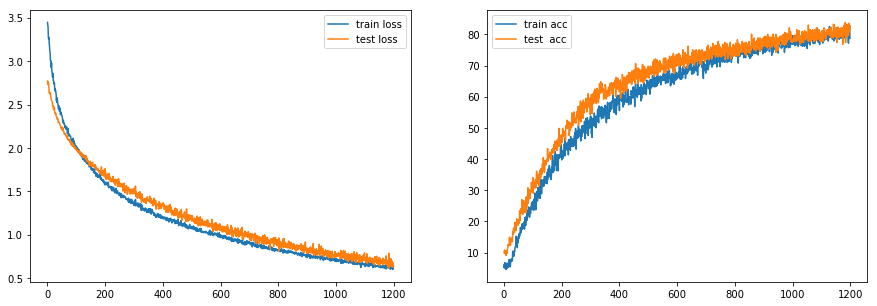

In [12]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()

In [13]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

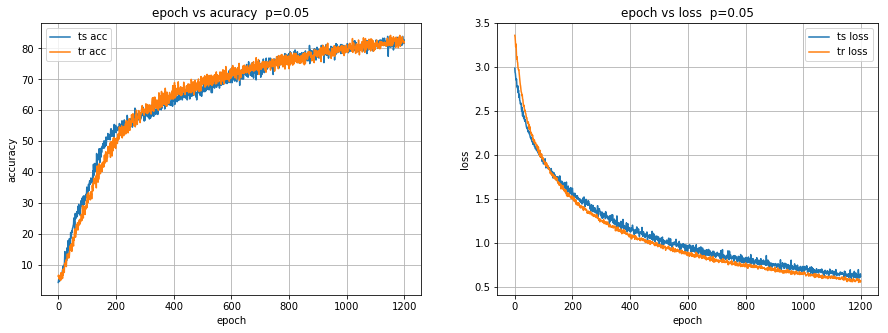

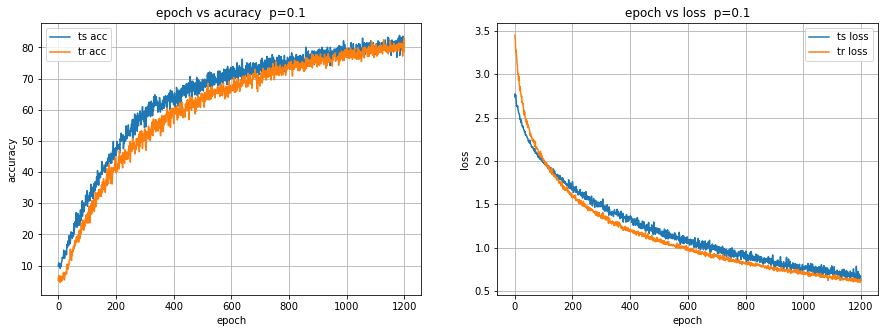

In [14]:
train = 0
test  = 1
acc   = 0
loss  = 1

x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[i,:,test,acc]
    ts_l = test_file[i,:,test,loss]
    tr_a = test_file[i,:,train,acc]
    tr_l = test_file[i,:,train,loss]
    
    plt.plot(x,ts_a,label='ts acc')
    plt.plot(x,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x,ts_l,label='ts loss')
    plt.plot(x,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    